## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2022.

## Assignment 2 - Task 1: Optimization

In this task, we introduce several improved stochastic gradient descent (SGD) based optimization methods. 

Plain/naive SGD is a reasonable method to update neural network parameters. However, there exists two main drawbacks. 

First, to make SGD perform well, one would need to find an appropriate learning rate and a good initial value for the prameters. Otherwise, the network will get stuck if the learning rate is small, or it will diverge if the learning rate is too large. In reality, since we have no prior knowledge about the training data, it is not trivial to find a good learning rate manually. Also, when the network becomes deeper, for each layer one may need to set a different learning rate. 

The second issue is that SGD follows strictly to the gradients of the batched data when updating the parameters. This can be problematic with real-world problems as has been demonstrated in the lectures. 

There are also other common limitations including the lack of sufficient training data. This can cause the training to get stuck when using the naive SGD method. These are the limitations of plain SGD, which are motivators for creating and using improved SGD-based methods. 

To seek for improvements of naive SGD, one can rely on momentum, parameter estimation and adaptive learning rate methods. Here, you are going to experiment with **SGD with momentum**, **SGD with Nesterov momentum**, **Adam**, **SGD with momentum & backtrace** and compare them against one another.

Consult the slides and [text book](https://www.deeplearningbook.org) for details. Here is also [a useful link](http://ruder.io/optimizing-gradient-descent/) to learn more about some methods used in this task. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Import modules
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

## Load Fashion-MNIST

Here we use a small dataset with only 2500 samples to simulate the "lack-of-data" situation.

In [2]:
# Load the raw Fashion-MNIST data.
train, val = fashion_mnist.load_data()

X_train_raw, y_train = train
X_val_raw, y_val = val

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_val = X_val_raw.reshape((X_val_raw.shape[0], X_val_raw.shape[1]**2))

#Consider a subset of 2500 samples of the 60000 total images (indexed 10000 ~ 12500)
X_val = X_train[10000:10500,:]
y_val = y_train[10000:10500]
X_train = X_train[10500:12500,:]
y_train = y_train[10500:12500]

mean_image = np.mean(X_train, axis=0).astype(np.float32)
X_train = X_train.astype(np.float32) - mean_image
X_val = X_val.astype(np.float32) - mean_image

# We have vectorized the data for you. That is, we flatten the 32×32×3 images into 1×3072 Numpy arrays.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

Training data shape:  (2000, 784)
Training labels shape:  (2000,)
Validation data shape:  (500, 784)
Validation labels shape:  (500,)


## Part 1: Implement Several Optimizers

Instructors provide code snippets for testing student code implementations.

The best anticipated achievable accuracies are specific to each algorithm.

In [3]:
from utils.neuralnets.mlp import MLP

### Basics

Assume that the goal is to optimize an objective function $L$ parametrized by $\theta \in R^d$, the update rule of an iterative optimization algorithm in general can be formulated as

$$\theta_{t+1} \gets \theta_t + \alpha_t p_t$$

where $\alpha > 0$ is the step size and $p$ is the direction of the update. 

Both $\alpha$ and $p$ can be proposed in several ways which result in different optimizers with different performances. 

Note that in the equations, we ***DO NOT*** take learning rate decay into consideration. 

### Original SGD with learning rate decay (for comparison purposes only)

Let the gradient of $L$ w.r.t $\theta$ at time step $t$ be given by

$$g_t = \nabla_{\theta} L(\theta_t)$$

and $\theta_t$ denotes the values of the parameters at time $t$. 

SGD (Stochastic Gradient Descent) algorithm is formulated as

$$\theta_{t+1} = \theta_t - \eta g_t$$

where $\eta$ is the ***learning rate***. 

The final accuracy you should expect is arround 0.1-0.3. 

In [9]:
from utils.optimizers import SGDOptim

model = MLP(input_dim=X_train.shape[1], hidden_dims=[100, 100], num_classes=10, weight_scale=1e-3, l2_reg=0.0)
optimizer = SGDOptim()
hist_sgd = optimizer.train(model, X_train, y_train, X_val, y_val, 
                           num_epoch=15, batch_size=200, learning_rate=1e-2, learning_decay=0.95, 
                           verbose=False, record_interval=1)

number of batches for training: 10
epoch 1: valid acc = 0.116, new learning rate = 0.0095
epoch 2: valid acc = 0.192, new learning rate = 0.009025
epoch 3: valid acc = 0.192, new learning rate = 0.00857375
epoch 4: valid acc = 0.198, new learning rate = 0.0081450625
epoch 5: valid acc = 0.206, new learning rate = 0.007737809374999999
epoch 6: valid acc = 0.2, new learning rate = 0.007350918906249998
epoch 7: valid acc = 0.202, new learning rate = 0.006983372960937498
epoch 8: valid acc = 0.208, new learning rate = 0.006634204312890623
epoch 9: valid acc = 0.2, new learning rate = 0.006302494097246091
epoch 10: valid acc = 0.206, new learning rate = 0.005987369392383786
epoch 11: valid acc = 0.206, new learning rate = 0.005688000922764597
epoch 12: valid acc = 0.212, new learning rate = 0.005403600876626367
epoch 13: valid acc = 0.214, new learning rate = 0.005133420832795048
epoch 14: valid acc = 0.206, new learning rate = 0.0048767497911552955
epoch 15: valid acc = 0.204, new learning

### Find a direction

As naively in SGD, the step size $\alpha_t = \eta$ is fixed to be the learning rate and the update direction $p_t = -g_t$ is simply the opposite of the gradient. Now let's look at some algorithms that try to use a different $p$. 

### SGD + Momentum

SGD + Momuntum algorithm is formulated as

$$\begin{aligned}
v_t &= \gamma v_{t-1} + \eta g_t \\
\theta_{t+1} &= \theta_t - v_t
\end{aligned}$$

where $v$ is often called the ***velocity*** (don't confuse with the "momentum" we'll talk about in Adam) and $\gamma$ is the decay factor. 

$v_0$ is initialized to be $\mathbb{0}$. 

The final accuracy you should expect is arround 0.4-0.6. 

<span style="color:red">__TODO:__</span> Implement SGD + Momentum by editing `SGDmomentumOptim` in **./utils/optimizers.py**

In [16]:
# Verification code for your implemention
# Please don't change anything.

from utils.optimizers import SGDmomentumOptim

model = MLP(input_dim=X_train.shape[1], hidden_dims=[100, 100], num_classes=10, l2_reg=0.0, weight_scale=1e-3, momentum=0.8)
optimizer = SGDmomentumOptim(model, momentum=0.8)
hist_sgd_momentum = optimizer.train(model, X_train, y_train, X_val, y_val, 
                                    num_epoch=15, batch_size=200, learning_rate=1e-2, 
                                    learning_decay=0.95, verbose=False, record_interval=1)

number of batches for training: 10
epoch 1: valid acc = 0.152, new learning rate = 0.0095
epoch 2: valid acc = 0.198, new learning rate = 0.009025
epoch 3: valid acc = 0.206, new learning rate = 0.00857375
epoch 4: valid acc = 0.218, new learning rate = 0.0081450625
epoch 5: valid acc = 0.218, new learning rate = 0.007737809374999999
epoch 6: valid acc = 0.214, new learning rate = 0.007350918906249998
epoch 7: valid acc = 0.214, new learning rate = 0.006983372960937498
epoch 8: valid acc = 0.346, new learning rate = 0.006634204312890623
epoch 9: valid acc = 0.408, new learning rate = 0.006302494097246091
epoch 10: valid acc = 0.416, new learning rate = 0.005987369392383786
epoch 11: valid acc = 0.424, new learning rate = 0.005688000922764597
epoch 12: valid acc = 0.41, new learning rate = 0.005403600876626367
epoch 13: valid acc = 0.44, new learning rate = 0.005133420832795048
epoch 14: valid acc = 0.524, new learning rate = 0.0048767497911552955
epoch 15: valid acc = 0.536, new learni

### Adam

Adam (Adaptive Momentum Estimation) algorithm can be formulated into three steps ($\beta_1, \beta_2 \in [0, 1]$ are all decay factors): 

- Estimate the first momentum (mean) of the gradients

$$\begin{aligned}
m_{t+1} &= \beta_1 m_t + (1 - \beta_1) g_t \\
\hat{m}_{t+1} &= \frac{m_{t+1}}{1 - \beta_1^t}
\end{aligned}$$

- Estimate the second momentum (variance) of the gradients

$$\begin{aligned}
v_{t+1} &= \beta_2 v_t + (1 - \beta_2) g_t^2 \\
\hat{v}_{t+1} &= \frac{v_{t+1}}{1 - \beta_2^t}
\end{aligned}$$

- Update the parameters ($\epsilon$ is a small value like 1e-8 serves to avoid zero-division)

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_{t+1}}+\epsilon} \odot \hat{m}_{t+1}$$

Here, $\epsilon$ is a small value (e.g. 1e-8) serves to avoid zero-division and $\odot$ denotes the Hadamard (element-wise) product. 

The final accuracy you should expect is arround 0.6-0.8. 

Both $m_0$ and $v_0$ are initialized to be $\mathbb{0}$. 

#### This is usually (not always) the optimal choice in practice. 

<span style="color:red">__TODO:__</span> Implement Adam by editing `AdamOptim` in **./utils/optimizers.py**

In [24]:
# Verification code for your implemention
# Please don't change anything.

from utils.optimizers import AdamOptim

model = MLP(input_dim=X_train.shape[1], hidden_dims=[100, 100], num_classes=10, l2_reg=0.0, weight_scale=1e-3)
optimizer = AdamOptim(model)
hist_adam = optimizer.train(model, X_train, y_train, X_val, y_val, 
                            num_epoch=15, batch_size=200, learning_rate=1e-3, 
                            learning_decay=0.95, verbose=False, record_interval=1)

number of batches for training: 10
epoch 1: valid acc = 0.208, new learning rate = 0.00095
epoch 2: valid acc = 0.22, new learning rate = 0.0009025
epoch 3: valid acc = 0.24, new learning rate = 0.000857375
epoch 4: valid acc = 0.368, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.378, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.408, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.57, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.602, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.624, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.668, new learning rate = 0.0005987369392383785
epoch 11: valid acc = 0.7, new learning rate = 0.0005688000922764595
epoch 12: valid acc = 0.694, new learning rate = 0.0005403600876626365
epoch 13: valid acc = 0.686, new learning rate = 0.0005133420832795047
epoch 14: valid acc = 0.758, new learning rate = 0.00048767497911552944
epoch 15: valid acc =

### Nadam

Nadam (Nesterov-accelerated Adam) algorithm can be simply derived from Adam. Recall the Adam update rule: 

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_{t+1}}+\epsilon} \odot \hat{m}_{t+1}$$

where

$$
\hat{m}_{t+1} = \frac{\beta_1 m_t}{1 - \beta_1^t} + \frac{(1 - \beta_1) g_t}{1 - \beta_1^t}
= \beta_1 \hat{m}_t + \frac{(1 - \beta_1) g_t}{1 - \beta_1^t}
$$ 

is an estimation of $m_{t+1}$ using the gradients at time $t$. So for Adam we actually have 

$$
\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_{t+1}}+\epsilon} \odot 
(\beta_1 \hat{m}_t + \frac{(1 - \beta_1) g_t}{1 - \beta_1^t})
$$

To perform a Nesterov-acceleration, we directly replace the $\hat{m}_t$ in the above equation with one step of look-ahead: 

$$\hat{m}_{t} \to \hat{m}_{t+1}$$

The final update rule is given by

$$
\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_{t+1}}+\epsilon} \odot 
(\beta_1 \hat{m}_{t+1} + \frac{(1 - \beta_1) g_t}{1 - \beta_1^t})
$$

All intermediate parameters including $m$ and $v$ are computed in the same way as in Adam. 

The final accuracy you should expect is arround 0.7-0.9. 

<span style="color:red">__TODO:__</span> Implement Nadam by editing `NadamOptim` in **./utils/optimizers.py**

In [26]:
# Verification code for your implemention
# Please don't change anything.

from utils.optimizers import NadamOptim

model = MLP(input_dim=X_train.shape[1], hidden_dims=[100, 100], num_classes=10, l2_reg=0.0, weight_scale=1e-3)
optimizer = NadamOptim(model, beta1=0.9, beta2=0.999, eps=1e-8)
hist_sgd_nadam = optimizer.train(model, X_train, y_train, X_val, y_val, 
                                         num_epoch=15, batch_size=200, learning_rate=1e-3, 
                                         learning_decay=0.95, verbose=False, record_interval=1)

number of batches for training: 10
epoch 1: valid acc = 0.232, new learning rate = 0.00095
epoch 2: valid acc = 0.402, new learning rate = 0.0009025
epoch 3: valid acc = 0.466, new learning rate = 0.000857375
epoch 4: valid acc = 0.528, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.612, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.672, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.77, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.782, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.808, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.82, new learning rate = 0.0005987369392383785
epoch 11: valid acc = 0.83, new learning rate = 0.0005688000922764595
epoch 12: valid acc = 0.836, new learning rate = 0.0005403600876626365
epoch 13: valid acc = 0.84, new learning rate = 0.0005133420832795047
epoch 14: valid acc = 0.846, new learning rate = 0.00048767497911552944
epoch 15: valid acc 

### Find a step size

Recall the general parameter update rule:

$$\theta_{t+1} \gets \theta_t + \alpha_t p_t$$

On the basis of SGD, we have already come across three other algorithms that seeks different $p_t$ (with $\alpha_t = \eta$):
- SGD + Momentum: $p_t = -\frac{\gamma}{\eta} m_{t-1} - g_t$ is the velocity
- Adam: $p_t =  -\frac{1}{\sqrt{\hat{v}_{t+1}}+\epsilon} \odot \hat{m}_{t+1}$ is the variance-adjusted estimated momentum
- Nadam: $p_t = -\frac{1}{\sqrt{\hat{v}}+\epsilon} \odot (\beta_1 \hat{m}_{t+1} + \frac{(1 - \beta_1) g_t}{1 - \beta_1^t})$ is the variance-adjusted estimated Nesterov-accelerated momentum

Now let's forget $p$ and look at another algorithm that tries to select different $\alpha$. 

### SGD + Momentum + Backtrace

Backtracing line search is a famous method that starts with a fairly large initial step size, and then repeatedly ***tries*** to search for a slightly smaller step until an appropriate one is met. For some loss function $L$, given an initial step size $\alpha_t > 0$ and an update direction $p_t$, the algorithms finds the appropriate step size following: 

> $\alpha \gets \alpha_t$ <br>
> while $L(\theta_t + \alpha p_t) > L(\theta_t) + c \alpha g_t^T p_t$: <br>
> &emsp; $\alpha \gets \rho \alpha$ <br>
> return $\alpha_t = \alpha$

For the loop criterion, observe that the LHS term 

$$L(\theta_t + \alpha p_t)$$ 

This is the value of the loss function **after** the potential update, which is forced to be smaller than a linear **upper bound** provided by the RHS term 

$$L(\theta_t) + c \alpha g_t^T p_t$$

This is call the **Armijo (sufficient decrease)** condition, stating that either after the current search the loss function decreases below the upperbound after the update, or else we **abandon the current search results**, find a new (smaller) step size and try again for another update. 

The step size in trial is decreased by a factor $\rho \in [0, 1]$ after every search step, and $c \in [0, 1]$ controls the **slope** ("hardness") of the linear upper bound. 

Since in here we're searching for $\theta_{t+1}$ in a linear subspace of $\theta$ parametrized by $\alpha$, these types of algorithms are called a [*Line Search*](https://optimization.cbe.cornell.edu/index.php?title=Line_search_methods). 

SGD + Momentum + Backtrace first proposes to find the update direction $p_t$ with momentum as discussed in previous sections, then tries to select an ideal $\alpha_t$ using backtracing line search. 

The accuracy you should expect is arround 0.7-0.9. This is NOT a commonly used method in DL. 

<span style="color:red">__TODO:__</span> Implement SGD + Momentum + Backtrace by editing `SGDmomtraceOptim` in **./utils/optimizers.py**

In [80]:
# Verification code for your implemention
# Please don't change anything.

from utils.optimizers import SGDmomtraceOptim

model = MLP(input_dim=X_train.shape[1], hidden_dims=[100, 100], num_classes=10, l2_reg=0.0, weight_scale=1e-3)
optimizer = SGDmomtraceOptim(model, momentum=0.8, alpha1=1, alpha2=0.9, max_searches=20, eps=1e-8)
hist_momtrace = optimizer.train(model, X_train, y_train, X_val, y_val, 
                                num_epoch=15, batch_size=200, learning_rate=1e-2, 
                                learning_decay=1, verbose=False, record_interval=1)

number of batches for training: 10
epoch 1: valid acc = 0.036, new learning rate = 0.01, num searches = 1
epoch 2: valid acc = 0.036, new learning rate = 0.01, num searches = 1
epoch 3: valid acc = 0.036, new learning rate = 0.01, num searches = 1
epoch 4: valid acc = 0.036, new learning rate = 0.01, num searches = 1
epoch 5: valid acc = 0.036, new learning rate = 0.01, num searches = 1
epoch 6: valid acc = 0.036, new learning rate = 0.01, num searches = 1
epoch 7: valid acc = 0.036, new learning rate = 0.01, num searches = 1
epoch 8: valid acc = 0.036, new learning rate = 0.01, num searches = 1
epoch 9: valid acc = 0.036, new learning rate = 0.01, num searches = 1
epoch 10: valid acc = 0.036, new learning rate = 0.01, num searches = 1
epoch 11: valid acc = 0.036, new learning rate = 0.01, num searches = 1
epoch 12: valid acc = 0.036, new learning rate = 0.01, num searches = 1
epoch 13: valid acc = 0.036, new learning rate = 0.01, num searches = 1
epoch 14: valid acc = 0.036, new learn

## Part 2: Comparison

<span style="color:red">__TODO:__</span> Run the following cells, which plot the loss, training accuracy, and validation accuracy curves of different optimizers.

In [28]:
loss_hist_sgd, train_acc_hist_sgd, val_acc_hist_sgd = hist_sgd
loss_hist_momentum, train_acc_hist_momentum, val_acc_hist_momentum = hist_sgd_momentum
loss_hist_adam, train_acc_hist_adam, val_acc_hist_adam = hist_adam
loss_hist_nesterov, train_acc_hist_nesterov, val_acc_hist_nesterov = hist_sgd_nadam
loss_hist_momtrace, train_acc_hist_momtrace, val_acc_hist_momtrace = hist_momtrace

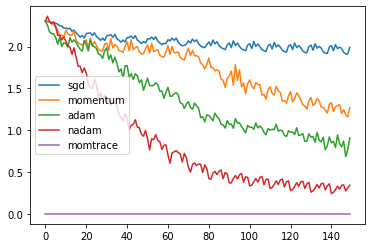

In [29]:
# Plot the training error curves for implemented optimizers
plt.plot(loss_hist_sgd, label="sgd")
plt.plot(loss_hist_momentum, label="momentum")
plt.plot(loss_hist_adam, label="adam")
plt.plot(loss_hist_nesterov, label="nadam")
plt.plot(loss_hist_momtrace, label="momtrace")
plt.legend()
plt.show()

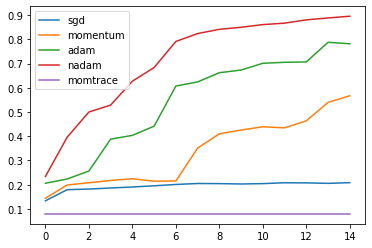

In [30]:
# Plot the training accuracy curves for implemented optimizers
plt.plot(train_acc_hist_sgd, label="sgd")
plt.plot(train_acc_hist_momentum, label="momentum")
plt.plot(train_acc_hist_adam, label="adam")
plt.plot(train_acc_hist_nesterov, label="nadam")
plt.plot(train_acc_hist_momtrace, label="momtrace")
plt.legend()
plt.show()

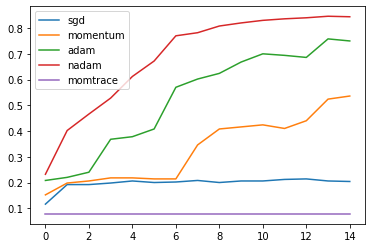

In [31]:
# Plot the validation accuracy curves for implemented optimizers
plt.plot(val_acc_hist_sgd, label="sgd")
plt.plot(val_acc_hist_momentum, label="momentum")
plt.plot(val_acc_hist_adam, label="adam")
plt.plot(val_acc_hist_nesterov, label="nadam")
plt.plot(val_acc_hist_momtrace, label="momtrace")
plt.legend()
plt.show()

<span style="color:red">__TODO:__</span> Describe your results, and discuss your understandings of these optimizers, such as their advantages or disadvantages and when to use them.

Answer: **[fill in herer]**.